In [ ]:
from leaderfollower.file_helper import loadTrialData, loadConfigData, loadBatch
from leaderfollower.data_helpers import getEvalFitnesses
from leaderfollower.plot_helpers import plotJointTrajectory, plotBatchPerformance, PerformanceMetric

In [183]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.axes import Axes
from matplotlib.lines import Line2D
import numpy as np
from typing import List, Dict, Optional
from enum import IntEnum

from leaderfollower.data_helpers import getEvalStatistics, getBestStatistics

class PerformanceMetric(IntEnum):
    BestTrainingTeam = 0
    EvaluationTeam = 1

def plotStatisticsAvg(avg, color):
    num_generations_arr = np.arange(avg.shape[0])
    plt.plot(num_generations_arr, avg, color=color, linewidth=4)

def plotStatisticsRange(upper_dev, lower_dev, upper_range, lower_range, color, plot_min_max_range=False):
    num_generations_arr = np.arange(upper_dev.shape[0])
    plt.fill_between(num_generations_arr, upper_dev.flatten(), lower_dev.flatten(), alpha=0.2, color=color)
    if plot_min_max_range:
        plt.fill_between(num_generations_arr, upper_range.flatten(), lower_range.flatten(), alpha=0.2, color=color)

def plotBatchPerformance(trial_datas_G: Optional[dict], trial_datas_D: Optional[dict], trial_datas_Dfollow: Optional[dict], \
                        plot_min_max_range: bool, computername: str, performance_metric: PerformanceMetric):
    plt.figure(0)

    num_stat_runs = len(trial_datas_G)

    if performance_metric.value == PerformanceMetric.BestTrainingTeam.value:
        getStatistics = getBestStatistics
        title = "Best Training Team"
    elif performance_metric.value == PerformanceMetric.EvaluationTeam.value:
        getStatistics = getEvalStatistics
        title = "Evaluation Team"

    # Get statistics for different reward structures
    # We plot the baselines first so that D-Indirect is on the top layer
    legend = []
    if trial_datas_G is not None:
        avg_G, std_dev_G, upper_err_G, lower_err_G, upper_G, lower_G = getStatistics(trial_datas_G)
        plotStatisticsAvg(avg_G, color='tab:blue')
        legend.append("$G$")
        num_generations_arr = np.arange(avg_G.shape[0])

    if trial_datas_D is not None:
        avg_D, std_dev_D, upper_err_D, lower_err_D, upper_D, lower_D = getStatistics(trial_datas_D)
        plotStatisticsAvg(avg_D, color='tab:orange')
        legend.append("$D$")
        num_generations_arr = np.arange(avg_D.shape[0])

    if trial_datas_Dfollow is not None:
        avg_Df, std_dev_Df, upper_err_Df, lower_err_Df, upper_Df, lower_Df = getStatistics(trial_datas_Dfollow)
        plotStatisticsAvg(avg_Df, color='tab:green')
        legend.append(r'$D^I$')
        num_generations_arr = np.arange(avg_Df.shape[0])

    # Automatically figure out how many generations were in here
    plt.ylim([0,1.01])
    plt.xlim([0,len(num_generations_arr)-1])

    # Add the standard error or min max plotting
    if trial_datas_G is not None: 
        plotStatisticsRange(upper_err_G, lower_err_G, upper_G, lower_G, 'tab:blue', plot_min_max_range)
    if trial_datas_D is not None:
        plotStatisticsRange(upper_err_D, lower_err_D, upper_D, lower_D, 'tab:orange', plot_min_max_range)
    if trial_datas_Dfollow is not None:
        plotStatisticsRange(upper_err_Df, lower_err_Df, upper_Df, lower_Df, 'tab:green', plot_min_max_range)

    plt.legend(legend, fontsize=20, loc="lower right")

    # plt.legend(["$G$", "$D$", r'$D_{follow}$'])

    plt.xlabel("Generations", fontsize=20)
    plt.ylabel("Performance", fontsize=20)
    plt.xticks(ticks=None, labels=None, fontsize=15)
    plt.yticks(ticks=None, labels=None, fontsize=15)
    plt.grid()
    # plt.title(title)

    # plt.xlim([0,150])

    plot_save_name = computername + " | stat_runs "+str(num_stat_runs)+" | "+title+" |"
    if trial_datas_G:
        plot_save_name += " G"
    if trial_datas_D:
        plot_save_name += " D"
    if trial_datas_Dfollow:
        plot_save_name += " Df"
    if plot_min_max_range:
        plot_save_name += " | full range"
    else:
        plot_save_name += " | std err"

    png_plot_save_name = "../../figures/png/" + plot_save_name + ".png"
    svg_plot_save_name = "../../figures/svg/" + plot_save_name + ".svg"

    print("Saving plot as ", png_plot_save_name)
    print("Saving plot as ", svg_plot_save_name)
    plt.savefig(png_plot_save_name)
    plt.savefig(svg_plot_save_name)

    plt.show()

def scaleRGB(rgb_values: List[int]):
    scaled_values = []
    for value in rgb_values:
        scaled_values.append(float(value)/255.)
    return tuple(scaled_values)

def plotJointTrajectorySubplot(trial_data: List[Dict], config: Dict, ax: Axes, generation: Optional[int], team_id: int | str, individual_plot: bool = True, sample_frequency: int = 1):
    if generation is None:
        generation = config["num_generations"]
    if team_id == "Eval":
        # Get the joint trajectory of the evaluation team
        # joint_trajectory = np.array('final_evaluation_teams'[generation].joint_trajectory).tolist()
        joint_trajectory = np.array(trial_data[generation]["evaluation_team"]["joint_trajectory"]).tolist()
    else:
        # First get the joint trajectory for this particular generation
        # Each element is a snapshot of all agent positions at a particular point in time
        # teams_in_evaluations is a global variable thanks to how python does things
        # joint_trajectory = np.array(teams_in_evaluations[generation][team_id].joint_trajectory).tolist()
        joint_trajectory = np.array(trial_data[generation]["training_teams"]["team_"+str(team_id)]["joint_trajectory"]).tolist()
    
    # I need the joint trajectory as a list of trajectories where each trajectory is a list of (x,y) tuples for a particular agent
    num_trajectories = len(joint_trajectory[0])
    list_of_trajectories = [[] for _ in range(num_trajectories)]
    for positions in joint_trajectory:
        for position, trajectory in zip(positions, list_of_trajectories):
            trajectory.append(tuple(position))

    # Now I need to set up variables for the plot

    # Get map dimensions for figuring the x and y limits of the graph
    map_dimensions = config["CCEA"]["config"]["BoidsEnv"]["config"]["map_dimensions"]
    map_dim_x = map_dimensions["x"]
    map_dim_y = map_dimensions["y"]

    # Use map dimensions to figure out correctly proportioned graph size
    # Keep x dimension the same and adjust the y dimension accordingly
    # fig_x = 5.
    # fig_y = fig_x * float(map_dim_y)/float(map_dim_x)

    # Get the number of leaders and followers
    num_leaders = config["CCEA"]["config"]["BoidsEnv"]["config"]["StateBounds"]["num_leaders"]
    num_followers = config["CCEA"]["config"]["BoidsEnv"]["config"]["StateBounds"]["num_followers"]

    # Set up the leader colors for coloring the trajectories
    leader_colors_rgb_raw = config["CCEA"]["config"]["BoidsEnv"]["config"]["Renderer"]["leader_colors"]
    leader_colors_scaled = [scaleRGB(color) for color in leader_colors_rgb_raw]
    leader_colors = []
    for leader_ind in range(num_leaders):
        leader_colors.append(leader_colors_scaled[leader_ind%len(leader_colors_scaled)])

    # Set up follower color
    follower_color = scaleRGB([73, 65, 109])

    # Set up leader color
    # leader_color = leader_colors[0]
    leader_color = scaleRGB([255, 209, 102])

    # Set up colors of agents for all trajectories
    # agent_colors = leader_colors + [follower_color]*num_followers

    # I reverse it so that the leader trajectories are plotted on top
    # for trajectory, agent_color in reversed(list(zip(list_of_trajectories, agent_colors))):
    #     xs, ys = zip(*trajectory)
    #     ax.plot(xs, ys, color=agent_color, marker='P')

    plot_marker_size = 10

    follower_trajectories = list_of_trajectories[num_leaders:]
    for trajectory in follower_trajectories:
        xs, ys = zip(*trajectory)
        ax.plot(xs[::sample_frequency], ys[::sample_frequency], color=follower_color, marker="s", markersize=plot_marker_size)

    leader_trajectories = list_of_trajectories[:num_leaders]
    for trajectory in leader_trajectories:
        xs, ys = zip(*trajectory)
        ax.plot(xs[::sample_frequency], ys[::sample_frequency], color=leader_color, marker="P", markersize=plot_marker_size)

    # Set up poi colors
    # For now just use the observed color because I don't yet save 
    # if a poi has been observed or not, so to determine that we would have to do a rollout or 
    # call some code to compute that
    poi_observed_color = scaleRGB([170, 80, 66]) #redwood color
    # poi_observed_color = scaleRGB([229, 79, 109]) # magenta color
    # poi_unobserved_color = scaleRGB([255, 0, 0])

    # Get the POI positions for the configuration
    # Later on this should plot the poi observation radius also
    poi_positions = config["CCEA"]["config"]["BoidsEnv"]["config"]["POISpawner"]["positions"]
    num_pois = len(poi_positions)
    poi_colors = [poi_observed_color]*num_pois
    for poi_position, poi_color in zip(poi_positions, poi_colors):
        ax.plot(poi_position[0], poi_position[1], marker="^", color=poi_color, markersize=plot_marker_size+5)

    # Add axes labels and a title
    if individual_plot:
        ax.set_xlabel('X', fontsize=20)
        ax.set_ylabel('Y', fontsize=20)
        ax.set_title('Joint Trajectory')

    # Limits according to map dimensions from config
    # ax.set_xlim([0, map_dim_x])
    # ax.set_ylim([0, map_dim_y])

    ax.set_xlim([0, 60])
    ax.set_ylim([0, 60])

    # Custom legend
    # leader_handles = [
    #     Line2D([0], [0], color=leader_color, lw=1) for leader_color in leader_colors
    # ]
    # leader_labels = ["Leader "+str(i+1) for i in range(num_leaders)]

    label_marker_size = 10

    leader_handle = Line2D([0], [0], color=leader_color, lw=1, marker="P", markersize=label_marker_size)
    leader_label = "Leader"

    follower_handle = Line2D([0], [0], color=follower_color, lw=1, marker="s", markersize=label_marker_size)
    follower_label = "Follower"

    poi_handle = Line2D([0], [0], color=poi_observed_color, lw=0, marker="^", markersize=label_marker_size+5)
    poi_label = "POI"

    # handles = leader_handles + [follower_handle] + [poi_handle]
    # labels = leader_labels + [follower_label] + [poi_label]

    handles = [leader_handle, follower_handle, poi_handle]
    labels = [leader_label, follower_label, poi_label]

    if individual_plot:
        ax.legend(handles, labels, ncol=1, fontsize=20)

    # Add a grid and make it look pretty
    ax.grid()
    ax.tick_params(
        axis='both',
        which='both',
        top = False,
        bottom = False,
        left = False,
        right = False,
        labelsize=15
    )
    # Give plot a gray background like ggplot.
    ax.set_facecolor('#EBEBEB')
    # Remove border around plot.
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # Style the grid.
    ax.grid(which='major', color='white', linewidth=1.2)
    ax.grid(which='minor', color='white', linewidth=0.6)

    # Set up the ticks for the grid
    xticks = np.linspace(0, int(map_dim_x - (map_dim_x%10)), int(map_dim_x/10.)+1)
    yticks = np.linspace(0, int(map_dim_y - (map_dim_y%10)), int(map_dim_y/10.)+1)

    ax.set_yticks(ticks=yticks, labels=None)
    ax.set_xticks(ticks=xticks, labels=None)

    # Remove labels for individual ticks if option is specified
    if not individual_plot:
        ax.set_xticks(ticks=xticks, labels=[])
        ax.set_yticks(ticks=yticks, labels=[])

    # Show the minor ticks and grid.
    # ax.minorticks_on()
    # Now hide the minor ticks (but leave the gridlines).
    # ax.tick_params(which='minor', bottom=False, left=False)

    ax.set_aspect('equal')
    # ax.set_aspect(1)

def plotJointTrajectory(trial_data: List[Dict], config: Dict, team_id: int | str, generation: Optional[int], plot_save_name: Optional[str] = None, sample_frequency: int = 1):
    """High level function for plotting joint trajectories. 
    team_id can be an integer representing the training team to plot
        or it can be the str Eval representing to plot the joint trajectory of the evaluation team
    generation should be an integer specifying which generation's team to use for the joint trajectory
        if generation is None then this should plot the joint trajectories from the last generation
    
    """

    leader_colors = config["CCEA"]["config"]["BoidsEnv"]["config"]["Renderer"]["leader_colors"]
    leader_colors = tuple(np.array(leader_colors)/255)

    if generation is None:
        generation = config["num_generations"]

    if team_id is None:
    # Figure out the grid size to place all of the plots in
        # Reference: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
        num_teams = config["CCEA"]["sub_population_size"]+1
        grid_len = int(np.ceil(np.sqrt(num_teams)))
        fig, axs = plt.subplots(nrows=grid_len, ncols=grid_len, figsize=(15,15), tight_layout=True)
        for team_id, ax in zip(np.arange(num_teams), axs.flat):
            # Add in case for plotting joint trajectory of the evaluation team
            if team_id == num_teams-1:
                team_id = "Eval"
                # Get the fitness of the evaluation team
                team_fitness = trial_data[generation]["evaluation_team"]["team_fitness"][0]
            else:
                # Get the fitness of the training team
                team_fitness = trial_data[generation]["training_teams"]["team_"+str(team_id)]["team_fitness"][0]

            plotJointTrajectorySubplot(trial_data=trial_data, config=config, ax=ax, generation=generation, team_id=team_id, individual_plot=False, sample_frequency=sample_frequency)
            # Objects for a custom legend that just lets me display important metadata
            class AnyObject:
                pass
            class AnyObjectHandler:
                def legend_artist(self, legend, orig_handle, fontsize, handlebox):
                    x0, y0 = handlebox.xdescent, handlebox.ydescent
                    width, height = handlebox.width, handlebox.height
                    patch = mpatches.Rectangle([x0, y0], 0, 0, facecolor='red',
                                            edgecolor='black', hatch='xx', lw=0,
                                            transform=handlebox.get_transform())
                    handlebox.add_artist(patch)
                    return patch
                
            # # Extract the fitness for this particular team
            # team_fitness = teams_in_evaluations[generation][team_id].fitness
            # team_fitness = trial_data[]

            # Format that fitness into a nice str
            fitness_str = f"{team_fitness:.3f}"

            # Custom legend that acts as a label for what team this plot is from
            # fake_handle = Line2D([0], [0], color='white', lw=0)
            fake_handle = AnyObject()
            fake_label = str(team_id) + " | " + fitness_str
            ax.legend([fake_handle], [fake_label], loc='upper right', handler_map={AnyObject: AnyObjectHandler()}, handlelength=-1)
            fig.suptitle("Generation "+str(generation))
        if team_id == "Eval":
            team_id = num_teams+1
        for ax in axs.flat[team_id+1:]:
            ax.tick_params(
                axis='both',
                which='both',
                top = False,
                bottom = False,
                left = False,
                right = False
            )
            ax.set_xticks(ticks=[], labels=[])
            ax.set_yticks(ticks=[], labels=[])
            # Remove border around plot.
            [ax.spines[side].set_visible(False) for side in ax.spines]

        fig.subplots_adjust(wspace=0, hspace=0)

        plt.show()
        pass
    # If team id is specified, then just plot that one joint trajectory
    else:
        # Get map dimensions for figuring the x and y limits of the graph
        map_dimensions = config["CCEA"]["config"]["BoidsEnv"]["config"]["map_dimensions"]
        map_dim_x = map_dimensions["x"]
        map_dim_y = map_dimensions["y"]

        # Use map dimensions to figure out correctly proportioned graph size
        # Keep x dimension the same and adjust the y dimension accordingly
        fig_x = 5.
        fig_y = fig_x * float(map_dim_y)/float(map_dim_x)

        # Set up the plot
        # fig = plt.figure(figsize=(fig_x, fig_y))
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        plotJointTrajectorySubplot(trial_data=trial_data, config=config, ax=ax, generation=generation, team_id=team_id, sample_frequency=sample_frequency)

        if plot_save_name is not None:
            png_plot_save_name = "../../figures/png/" + plot_save_name + ".png"
            svg_plot_save_name = "../../figures/svg/" + plot_save_name + ".svg"

            print("Saving plot as ", png_plot_save_name)
            print("Saving plot as ", svg_plot_save_name)
            plt.savefig(png_plot_save_name)
            plt.savefig(svg_plot_save_name)

        plt.show()

In [ ]:
"""Load in all of the data for the evaluation teams for the 5 leaders straight experiment"""
num_generations, trial_datas_Dfollow, trial_datas_D, trial_datas_G = loadBatch(
    computername="experiment_9a_5leaders",
    start_trial_num=59,
    num_stat_runs=20,
    tested_G = True,
    tested_D = True,
    tested_Dfollow = True,
    load_populations = False,
    load_evaluation_teams = True,
    load_training_teams = False,
    abs_results_path = "/home/gonzaeve/boids/leader-follower/"
)

Saving plot as  ../../figures/png/experiment_9a_5leaders | stat_runs 20 | Evaluation Team | G D Df | std err.png
Saving plot as  ../../figures/svg/experiment_9a_5leaders | stat_runs 20 | Evaluation Team | G D Df | std err.svg


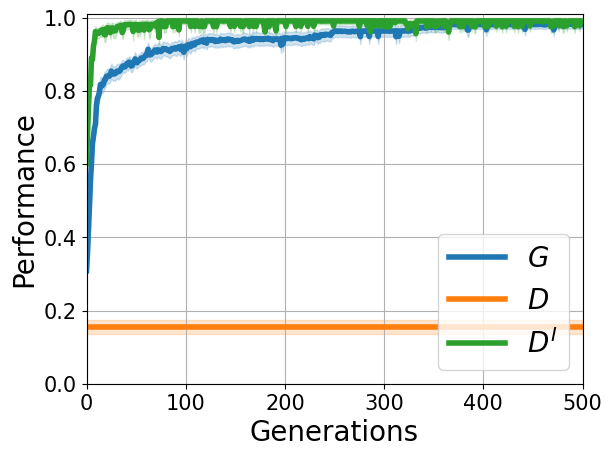

In [38]:
"""Plot the full batch for experiment 9a 5 leaders here"""
# from leaderfollower.plot_helpers import plotBatchPerformance, PerformanceMetric

plotBatchPerformance(
    trial_datas_G = trial_datas_G,
    trial_datas_D = trial_datas_D,
    trial_datas_Dfollow = trial_datas_Dfollow,
    plot_min_max_range=False,
    computername="experiment_9a_5leaders",
    performance_metric = PerformanceMetric.EvaluationTeam
)

In [ ]:
# trial_data = loadTrialData(trialname="trial_0", computername="experiment_9a_5leaders", load_populations=False, load_evaluation_teams=True, load_training_teams=False, abs_results_path="/home/gonzaeve/boids/leader-follower/")
# trial_data = trial_datas_Dfollow[0]
# config = loadConfigData(trialname="trial_0", computername="experiment_9a_5leaders", abs_results_path="/home/gonzaeve/boids/leader-follower/")

# plotJointTrajectory(trial_data, config, team_id="Eval", generation=None)

In [ ]:
"""Load in all of the data for the evaluation teams for the 15 leaders straight experiment"""
num_generations_15a, trial_datas_Dfollow_15a, trial_datas_D_15a, trial_datas_G_15a = loadBatch(
    computername="experiment_9a_15leaders",
    start_trial_num=59,
    num_stat_runs=20,
    tested_G = True,
    tested_D = True,
    tested_Dfollow = True,
    load_populations = False,
    load_evaluation_teams = True,
    load_training_teams = False,
    abs_results_path = "/home/gonzaeve/boids/leader-follower/"
)

Saving plot as  ../../figures/png/experiment_9a_15leaders | stat_runs 20 | Evaluation Team | G D Df | std err.png
Saving plot as  ../../figures/svg/experiment_9a_15leaders | stat_runs 20 | Evaluation Team | G D Df | std err.svg


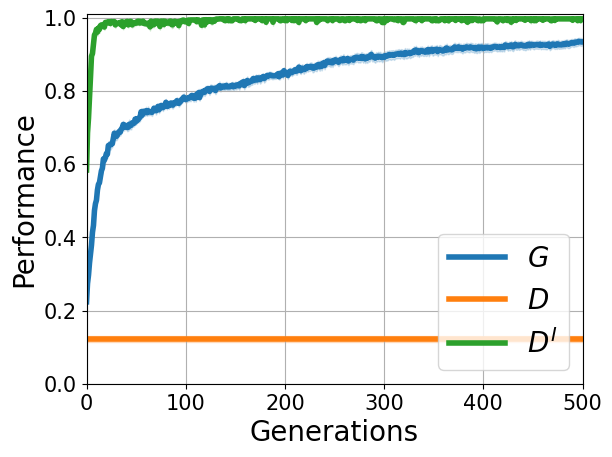

In [39]:
"""Plot the full batch for experiment 9a 15 leaders here"""
# from leaderfollower.plot_helpers import plotBatchPerformance, PerformanceMetric

plotBatchPerformance(
    trial_datas_G = trial_datas_G_15a,
    trial_datas_D = trial_datas_D_15a,
    trial_datas_Dfollow = trial_datas_Dfollow_15a,
    plot_min_max_range=False,
    computername="experiment_9a_15leaders",
    performance_metric = PerformanceMetric.EvaluationTeam
)

In [ ]:
"""Load in all of the data for the evaluation teams for the 25 leaders straight experiment"""
num_generations_25a, trial_datas_Dfollow_25a, trial_datas_D_25a, trial_datas_G_25a = loadBatch(
    computername="experiment_9a_25leaders",
    start_trial_num=59,
    num_stat_runs=20,
    tested_G = True,
    tested_D = True,
    tested_Dfollow = True,
    load_populations = False,
    load_evaluation_teams = True,
    load_training_teams = False,
    abs_results_path = "/home/gonzaeve/boids/leader-follower/"
)

Saving plot as  ../../figures/png/experiment_9a_25leaders | stat_runs 20 | Evaluation Team | G D Df | std err.png
Saving plot as  ../../figures/svg/experiment_9a_25leaders | stat_runs 20 | Evaluation Team | G D Df | std err.svg


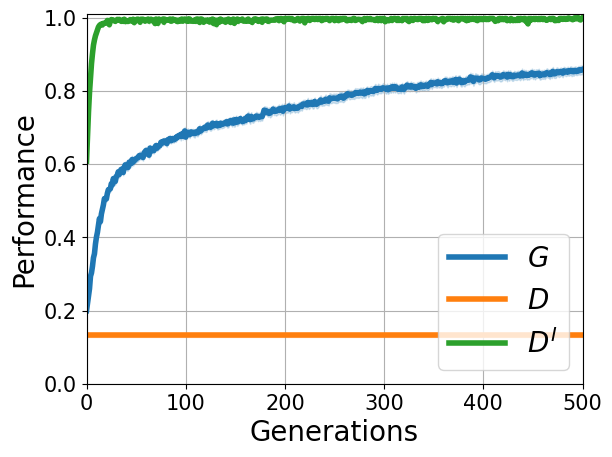

In [42]:
"""Plot the full batch for experiment 9a 25 leaders here"""
# from leaderfollower.plot_helpers import plotBatchPerformance, PerformanceMetric

plotBatchPerformance(
    trial_datas_G = trial_datas_G_25a,
    trial_datas_D = trial_datas_D_25a,
    trial_datas_Dfollow = trial_datas_Dfollow_25a,
    plot_min_max_range=False,
    computername="experiment_9a_25leaders",
    performance_metric = PerformanceMetric.EvaluationTeam
)

In [ ]:
from typing import List, Dict, Optional
from leaderfollower.data_helpers import getEvalStatistics, getBestStatistics
def getSweepStatistics(
        trial_datas_sweep: List[List[Dict]],
        performance_metric: PerformanceMetric,
        generation: Optional[int] = None,
    ):

    if performance_metric.value == PerformanceMetric.BestTrainingTeam.value:
        getStatistics = getBestStatistics
    elif performance_metric.value == PerformanceMetric.EvaluationTeam.value:
        getStatistics = getEvalStatistics

    if generation is None:
        generation = -1

    # This gets the final value for each of these statistics across
    # the different batches
    avg_sweep = []
    std_dev_sweep = []
    upper_err_sweep = []
    lower_err_sweep = []
    upper_range_sweep = []
    lower_range_sweep = []

    for trial_datas in trial_datas_sweep:
        avg, std_dev, upper_err, lower_err, upper_range, lower_range = getStatistics(trial_datas)
        avg_sweep.append(avg[generation])
        std_dev_sweep.append(std_dev[generation])
        upper_err_sweep.append(upper_err[generation])
        lower_err_sweep.append(lower_err[generation])
        upper_range_sweep.append(upper_range[generation])
        lower_range_sweep.append(lower_range[generation])

    return avg_sweep, std_dev_sweep, upper_err_sweep, lower_err_sweep, upper_range_sweep, lower_range_sweep

def getAllSweepStatistics(
        trial_datas_sweep_G: List[List[Dict]],
        trial_datas_sweep_D: List[List[Dict]],
        trial_datas_sweep_Dfollow: List[List[Dict]],
        performance_metric: PerformanceMetric,
        generation: Optional[int] = None       
    ):
    G_sweep_stats = getSweepStatistics(trial_datas_sweep_G, performance_metric, generation)
    D_sweep_stats = getSweepStatistics(trial_datas_sweep_D, performance_metric, generation)
    Dfollow_sweep_stats = getSweepStatistics(trial_datas_sweep_Dfollow, performance_metric, generation)
    return G_sweep_stats, D_sweep_stats, Dfollow_sweep_stats

Saving plot as  ../../figures/png/experiment_9a_sweep.png
Saving plot as  ../../figures/svg/experiment_9a_sweep.svg


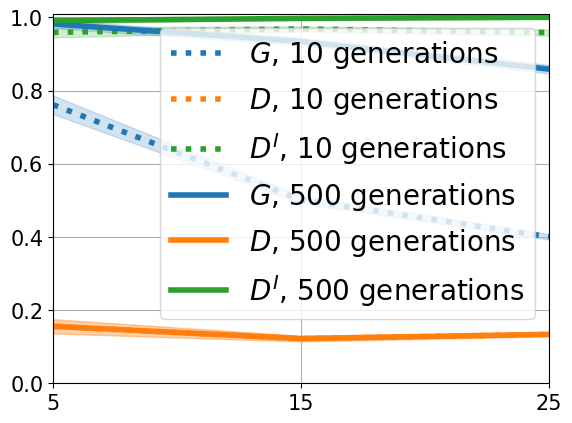

In [63]:
def plotAllSweepStatistics(
        trial_datas_sweep_G: List[List[Dict]],
        trial_datas_sweep_D: List[List[Dict]],
        trial_datas_sweep_Dfollow: List[List[Dict]],
        performance_metric: PerformanceMetric,
        generations: Optional[List[int]]=None
    ):
    plt.figure(0)
    legend = []
    for ind, generation in enumerate(generations):
        G_sweep_stats, D_sweep_stats, Dfollow_sweep_stats = getAllSweepStatistics(trial_datas_sweep_G, trial_datas_sweep_D, trial_datas_sweep_Dfollow, performance_metric, generation)
        avg_G, std_dev_G, upper_err_G, lower_err_G, upper_range_G, lower_range_G = G_sweep_stats
        avg_D, std_dev_D, upper_err_D, lower_err_D, upper_range_D, lower_range_D = D_sweep_stats
        avg_Dfollow, std_dev_Dfollow, upper_err_Dfollow, lower_err_Dfollow, upper_range_Dfollow, lower_range_Dfollow = Dfollow_sweep_stats

        line_style = "-"
        if ind == 0:
            line_style = ":"

        plt.plot(list(range(len(avg_G))), avg_G, color='tab:blue', linestyle=line_style, linewidth=4)
        plt.plot(list(range(len(avg_D))), avg_D, color='tab:orange', linestyle=line_style, linewidth=4)
        plt.plot(list(range(len(avg_Dfollow))), avg_Dfollow, color='tab:green', linestyle=line_style, linewidth=4)
        legend.append(f"$G$, {generation} generations")
        legend.append(f"$D$, {generation} generations")
        legend.append(f"$D^I$, {generation} generations")

    for ind, generation in enumerate(generations):
        G_sweep_stats, D_sweep_stats, Dfollow_sweep_stats = getAllSweepStatistics(trial_datas_sweep_G, trial_datas_sweep_D, trial_datas_sweep_Dfollow, performance_metric, generation)
        avg_G, std_dev_G, upper_err_G, lower_err_G, upper_range_G, lower_range_G = G_sweep_stats
        avg_D, std_dev_D, upper_err_D, lower_err_D, upper_range_D, lower_range_D = D_sweep_stats
        avg_Dfollow, std_dev_Dfollow, upper_err_Dfollow, lower_err_Dfollow, upper_range_Dfollow, lower_range_Dfollow = Dfollow_sweep_stats

        line_style = "-"
        if ind == 0:
            line_style = ":"

        plt.fill_between(list(range(len(upper_err_G))), np.array(upper_err_G).flatten(), np.array(lower_err_G).flatten(), alpha=0.2, color='tab:blue')
        plt.fill_between(list(range(len(upper_err_D))), np.array(upper_err_D).flatten(), np.array(lower_err_D).flatten(), alpha=0.2, color='tab:orange')
        plt.fill_between(list(range(len(upper_err_Dfollow))), np.array(upper_err_Dfollow).flatten(), np.array(lower_err_Dfollow).flatten(), alpha=0.2, color='tab:green')

        
    plt.legend(legend, fontsize=20)
    plt.ylim([0, 1.01])
    plt.xlim([0,2])
    plt.grid()

    plt.xticks(ticks=[0,1,2], labels=[5,15,25], fontsize=15)
    plt.yticks(ticks=None, labels=None, fontsize=15)

    plot_save_name = "experiment_9a_sweep"

    png_plot_save_name = "../../figures/png/" + plot_save_name + ".png"
    svg_plot_save_name = "../../figures/svg/" + plot_save_name + ".svg"

    print("Saving plot as ", png_plot_save_name)
    print("Saving plot as ", svg_plot_save_name)
    plt.savefig(png_plot_save_name)
    plt.savefig(svg_plot_save_name)

plotAllSweepStatistics(
    trial_datas_sweep_G = [trial_datas_G, trial_datas_G_15a, trial_datas_G_25a],
    trial_datas_sweep_D = [trial_datas_D, trial_datas_D_15a, trial_datas_D_25a],
    trial_datas_sweep_Dfollow = [trial_datas_Dfollow, trial_datas_Dfollow_15a, trial_datas_Dfollow_25a],
    performance_metric = PerformanceMetric.EvaluationTeam,
    generations = [10, 500]
)

In [65]:
# Get a trial that learned with DI
trial_data_5a_jt = loadTrialData(
    trialname="trial_40",
    computername="experiment_9a_5leaders",
    load_populations=True,
    load_evaluation_teams=True,
    load_training_teams=True,
    abs_results_path="/home/gonzaeve/boids/leader-follower/"
)

100%|██████████| 501/501 [02:33<00:00,  3.27it/s]


In [74]:
config_data_5a_jt = loadConfigData(
    trialname="trial_40",
    computername="experiment_9a_5leaders",
    abs_results_path="/home/gonzaeve/boids/leader-follower/"
)

Saving plot as  ../../figures/png/5ajt.png
Saving plot as  ../../figures/svg/5ajt.svg


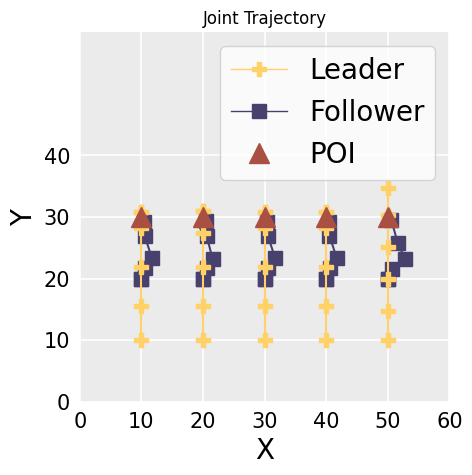

In [184]:
plotJointTrajectory(
    trial_data=trial_data_5a_jt,
    config=config_data_5a_jt,
    team_id="Eval",
    generation=None,
    plot_save_name="5ajt",
    sample_frequency=10
    )

Saving plot as  ../../figures/png/5ajt_10gens.png
Saving plot as  ../../figures/svg/5ajt_10gens.svg


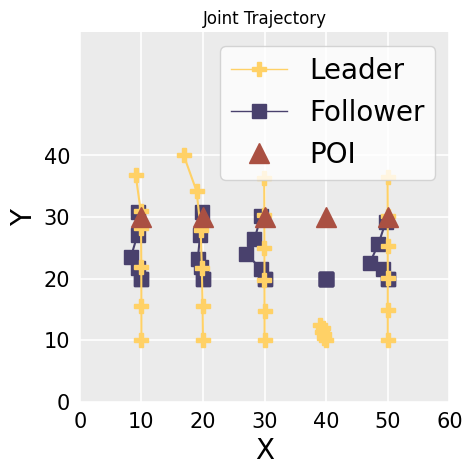

In [187]:
plotJointTrajectory(
    trial_data=trial_data_5a_jt,
    config=config_data_5a_jt,
    team_id="Eval",
    generation=10,
    plot_save_name="5ajt_10gens",
    sample_frequency=10
    )

In [185]:
# Get a trial from a that learned with G
trial_data_5a_jt_G = loadTrialData(
    trialname="trial_0",
    computername="experiment_9a_5leaders",
    load_populations=True,
    load_evaluation_teams=True,
    load_training_teams=True,
    abs_results_path="/home/gonzaeve/boids/leader-follower/"
)

100%|██████████| 501/501 [02:33<00:00,  3.26it/s]


Saving plot as  ../../figures/png/5ajt_G.png
Saving plot as  ../../figures/svg/5ajt_G.svg


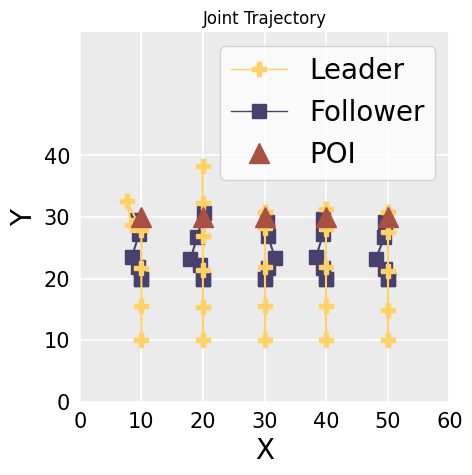

In [186]:
plotJointTrajectory(
    trial_data=trial_data_5a_jt_G,
    config=config_data_5a_jt,
    team_id="Eval",
    generation=None,
    plot_save_name="5ajt_G",
    sample_frequency=10
    )

Saving plot as  ../../figures/png/5ajt_G_10gens.png
Saving plot as  ../../figures/svg/5ajt_G_10gens.svg


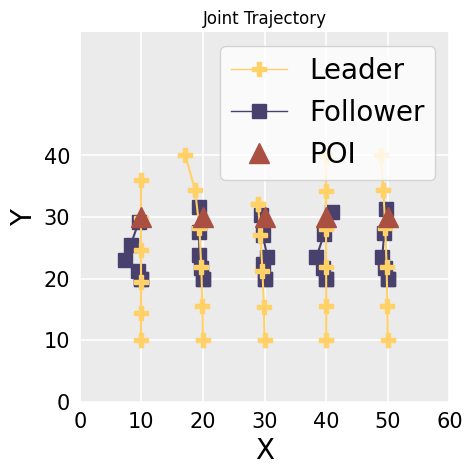

In [188]:
plotJointTrajectory(
    trial_data=trial_data_5a_jt_G,
    config=config_data_5a_jt,
    team_id="Eval",
    generation=10,
    plot_save_name="5ajt_G_10gens",
    sample_frequency=10
    )

In [177]:
# Get a trial that learned with DI on the scattered POIs
trial_data_5b_jt = loadTrialData(
    trialname="trial_40",
    computername="experiment_9b_5leaders",
    load_populations=True,
    load_evaluation_teams=True,
    load_training_teams=True,
    abs_results_path="/home/gonzaeve/boids/leader-follower/"
)
# Grab the corresponding config.
# We're using the b config mostly so that we get the POI locations right
config_data_5b_jt = loadConfigData(
    trialname="trial_40",
    computername="experiment_9b_5leaders",
    abs_results_path="/home/gonzaeve/boids/leader-follower/"
)

100%|██████████| 501/501 [02:38<00:00,  3.15it/s]


It looks like I should be looking at trials that had 15 or 25 pairs because the discrepancy isn't as clear cut with the smaller trials

In [195]:
# Get a trial that learned with DI
trial_data_25a_jt_DI = trial_datas_Dfollow_25a[0]
config_data_25a_jt_DI = loadConfigData(
    trialname="trial_40",
    computername="experiment_9a_25leaders",
    abs_results_path="/home/gonzaeve/boids/leader-follower/"
)

In [198]:
%matplotlib qt
plotJointTrajectory(
    trial_data=trial_data_25a_jt_DI,
    config=config_data_25a_jt_DI,
    team_id="Eval",
    generation=None,
    plot_save_name="25ajt_DI_finished",
    sample_frequency=10
    )

Saving plot as  ../../figures/png/25ajt_DI_finished.png
Saving plot as  ../../figures/svg/25ajt_DI_finished.svg



(python:7609): Gtk-CRITICAL **: 17:19:38.936: gtk_tree_view_scroll_to_cell: assertion 'tree_view->priv->tree != NULL' failed

(python:7609): Gtk-CRITICAL **: 17:19:38.965: gtk_tree_view_scroll_to_cell: assertion 'tree_view->priv->tree != NULL' failed

(python:7609): Gtk-CRITICAL **: 17:19:38.975: gtk_tree_view_scroll_to_cell: assertion 'tree_view->priv->tree != NULL' failed

(python:7609): Gtk-CRITICAL **: 17:19:38.992: gtk_tree_view_scroll_to_cell: assertion 'tree_view->priv->tree != NULL' failed

(python:7609): Gtk-CRITICAL **: 17:19:39.008: gtk_tree_view_scroll_to_cell: assertion 'tree_view->priv->tree != NULL' failed

(python:7609): Gtk-CRITICAL **: 17:19:39.025: gtk_tree_view_scroll_to_cell: assertion 'tree_view->priv->tree != NULL' failed

(python:7609): Gtk-CRITICAL **: 17:19:39.042: gtk_tree_view_scroll_to_cell: assertion 'tree_view->priv->tree != NULL' failed

(python:7609): Gtk-CRITICAL **: 17:19:39.058: gtk_tree_view_scroll_to_cell: assertion 'tree_view->priv->tree != NULL'

In [201]:
%matplotlib qt
plotJointTrajectory(
    trial_data=trial_data_25a_jt_DI,
    config=config_data_25a_jt_DI,
    team_id="Eval",
    generation=10,
    plot_save_name="25ajt_DI_10",
    sample_frequency=10
    )

Saving plot as  ../../figures/png/25ajt_DI_10.png
Saving plot as  ../../figures/svg/25ajt_DI_10.svg


In [199]:
# Get a trial that learned with G
trial_data_25a_jt_G = trial_datas_G_25a[0]
config_data_25a_jt_G = loadConfigData(
    trialname="trial_0",
    computername="experiment_9a_25leaders",
    abs_results_path="/home/gonzaeve/boids/leader-follower/"
)

In [200]:
%matplotlib qt
plotJointTrajectory(
    trial_data=trial_data_25a_jt_G,
    config=config_data_25a_jt_G,
    team_id="Eval",
    generation=None,
    plot_save_name="25ajt_G_finished",
    sample_frequency=10
    )

Saving plot as  ../../figures/png/25ajt_G_finished.png
Saving plot as  ../../figures/svg/25ajt_G_finished.svg


In [202]:
%matplotlib qt
plotJointTrajectory(
    trial_data=trial_data_25a_jt_G,
    config=config_data_25a_jt_G,
    team_id="Eval",
    generation=10,
    plot_save_name="25ajt_G_10",
    sample_frequency=10
    )

Saving plot as  ../../figures/png/25ajt_G_10.png
Saving plot as  ../../figures/svg/25ajt_G_10.svg
